# Setting Up the Environment

In [67]:
# Install required packages
!pip install pandas scikit-learn tensorflow matplotlib seaborn statsmodels pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00


In [68]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Data Collection and Loading

In [69]:
# Data Collection and Loading
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Load the dataset
model_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Project_4/Resources/weather_energy_merged.csv')

In [71]:
# Convert 'date' column to datetime format
model_df['date'] = pd.to_datetime(model_df['date'])

# Check the result
print(model_df.head())

        state st_abb       date  tmin (f)  tmax (f)  tavg (f)      ppt  \
0     Alabama     AL 2001-01-01   29.1524   51.8234   40.4870  119.501   
1    Arkansas     AR 2001-01-01   26.6612   45.7412   36.2012   88.598   
2     Arizona     AZ 2001-01-01   28.2722   51.9206   40.0964   41.955   
3  California     CA 2001-01-01   31.7372   52.7198   42.2276   87.828   
4    Colorado     CO 2001-01-01   11.2748   37.4252   24.3500   25.485   

     coal  natural gas  petroleum coke  petroleum liquids  
0  3076.0      210.654             0.0             46.240  
1  1320.0       77.895             0.0             30.192  
2  1773.0      194.994             0.0             36.448  
3   154.0     2879.145            94.0             85.000  
4  1777.0      176.526             0.0              7.072  


In [72]:
# Set 'date' as the index
model_df.set_index('date', inplace=True)

In [73]:
# Filter by "TX" to only get Texas data
filtered_df = model_df[model_df['st_abb'] == 'TX']
filtered_df = filtered_df.drop(columns=["state", "st_abb"])  # Drop unnecessary columns
filtered_df.head()

,tmin (f),tmax (f),tavg (f),ppt,coal,natural gas,petroleum coke,petroleum liquids
date,,,,,,,,
2001-01-01,32.5508,53.7674,43.1600,58.369,8003.0,3969.540,52.0,351.424
2001-02-01,39.1658,62.9168,51.0404,50.657,7221.0,3412.611,46.0,66.096
2001-03-01,41.4464,63.2606,52.3526,80.271,7610.0,3909.708,63.0,35.088
2001-04-01,54.9140,79.4192,67.1666,18.715,6900.0,4188.051,47.0,19.040
2001-05-01,61.4606,86.2250,73.8428,72.098,8164.0,4701.861,58.0,8.976


In [74]:
# Check data types and missing values
print(filtered_df.dtypes)
print(filtered_df[['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt', 'coal']].isnull().sum())

tmin (f)             float64
tmax (f)             float64
tavg (f)             float64
ppt                  float64
coal                 float64
natural gas          float64
petroleum coke       float64
petroleum liquids    float64
dtype: object
tmin (f)    0
tmax (f)    0
tavg (f)    0
ppt         0
coal        0
dtype: int64


# Visualizing the Data

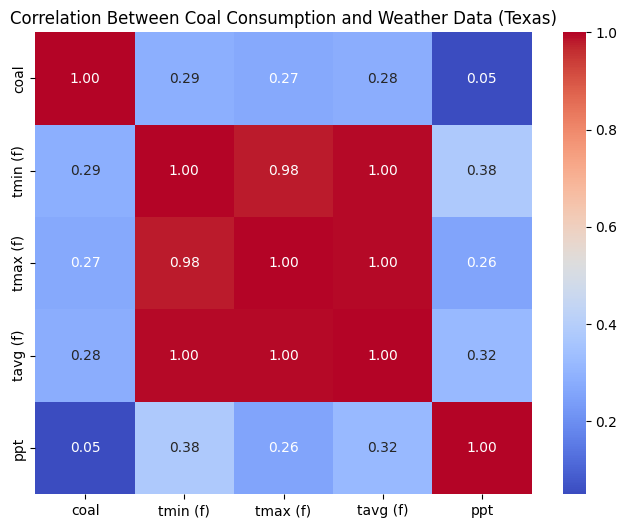

In [75]:
# Calculate correlation between energy consumption and weather variables
correlation = filtered_df[['coal', 'tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Coal Consumption and Weather Data (Texas)")
plt.show()

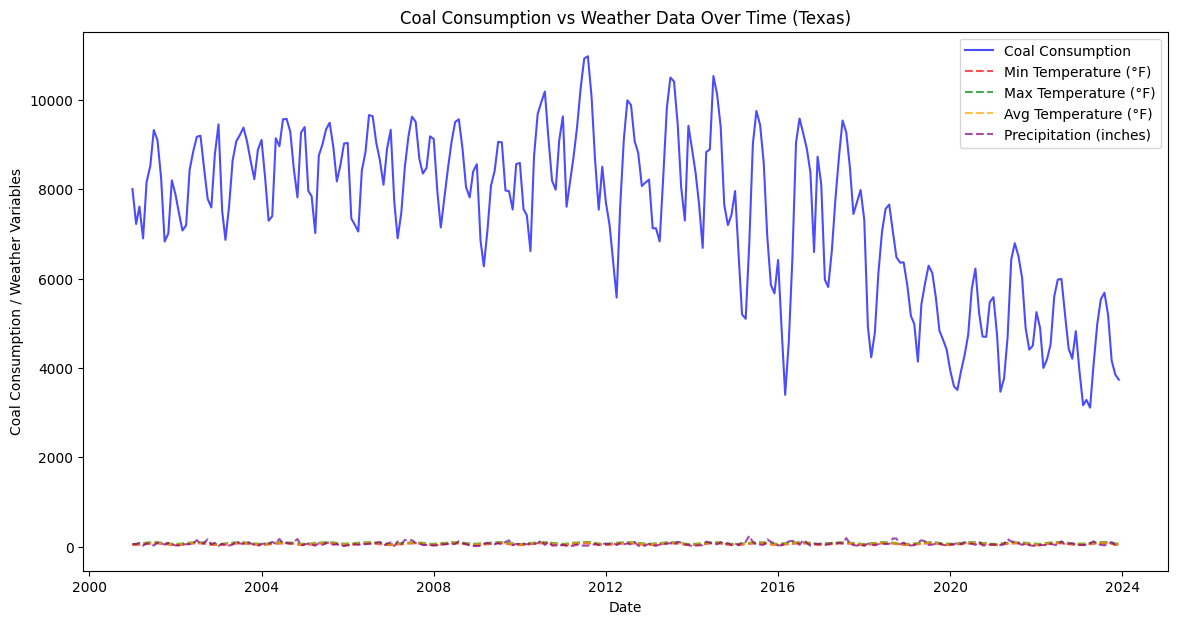

In [76]:
# Plot energy consumption and weather data on the same graph
plt.figure(figsize=(14, 7))

# Plot total energy consumption (in one color)
plt.plot(filtered_df.index, filtered_df['coal'], label='Coal Consumption', color='blue', alpha=0.7)

# Plot temperature (min, max, and average) on secondary y-axis
plt.plot(filtered_df.index, filtered_df['tmin (f)'], label='Min Temperature (°F)', color='red', linestyle='--', alpha=0.7)
plt.plot(filtered_df.index, filtered_df['tmax (f)'], label='Max Temperature (°F)', color='green', linestyle='--', alpha=0.7)
plt.plot(filtered_df.index, filtered_df['tavg (f)'], label='Avg Temperature (°F)', color='orange', linestyle='--', alpha=0.7)

# Plot precipitation
plt.plot(filtered_df.index, filtered_df['ppt'], label='Precipitation (inches)', color='purple', linestyle='--', alpha=0.7)

# Set labels and title
plt.title('Coal Consumption vs Weather Data Over Time (Texas)')
plt.xlabel('Date')
plt.ylabel('Coal Consumption / Weather Variables')
plt.legend()
plt.show()


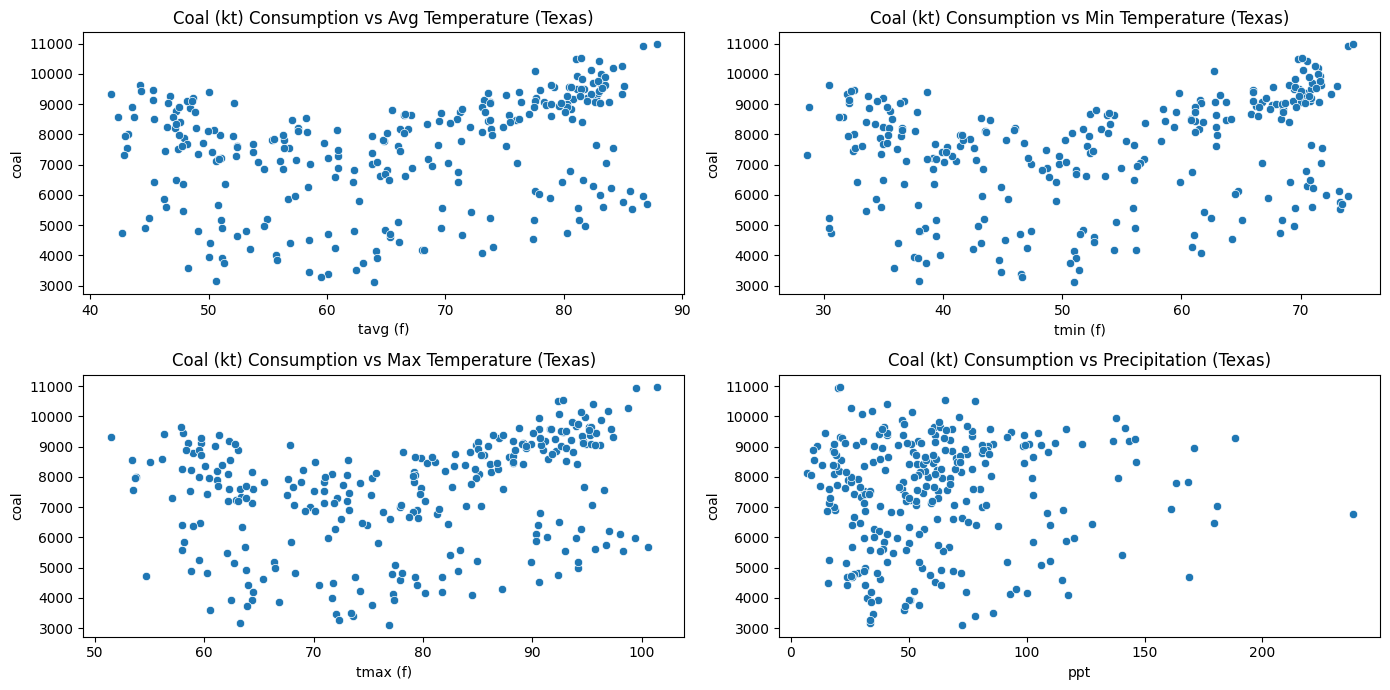

In [77]:
# Scatter plots to examine the relationship between energy consumption and weather variables
plt.figure(figsize=(14, 7))

# Scatter plot for energy consumption vs average temperature
plt.subplot(2, 2, 1)
sns.scatterplot(x=filtered_df['tavg (f)'], y=filtered_df['coal'])
plt.title('Coal (kt) Consumption vs Avg Temperature (Texas)')

# Scatter plot for energy consumption vs min temperature
plt.subplot(2, 2, 2)
sns.scatterplot(x=filtered_df['tmin (f)'], y=filtered_df['coal'])
plt.title('Coal (kt) Consumption vs Min Temperature (Texas)')

# Scatter plot for energy consumption vs max temperature
plt.subplot(2, 2, 3)
sns.scatterplot(x=filtered_df['tmax (f)'], y=filtered_df['coal'])
plt.title('Coal (kt) Consumption vs Max Temperature (Texas)')

# Scatter plot for energy consumption vs precipitation
plt.subplot(2, 2, 4)
sns.scatterplot(x=filtered_df['ppt'], y=filtered_df['coal'])
plt.title('Coal (kt) Consumption vs Precipitation (Texas)')

plt.tight_layout()
plt.show()

# Statistical Modeling (using Linear Regression)

In [78]:
# Prepare the data for the model
X = filtered_df[['tmin (f)', 'tmax (f)', 'tavg (f)']]  # Weather variables
y = filtered_df['coal']  # Coal consumption

In [79]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Initialize and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [81]:
# Make predictions
y_pred = model.predict(X_test)

In [82]:
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 1771.1726547304033
Mean Absolute Error (MAE): 1494.4810381677235
R-squared (R²): 0.06320799831572177


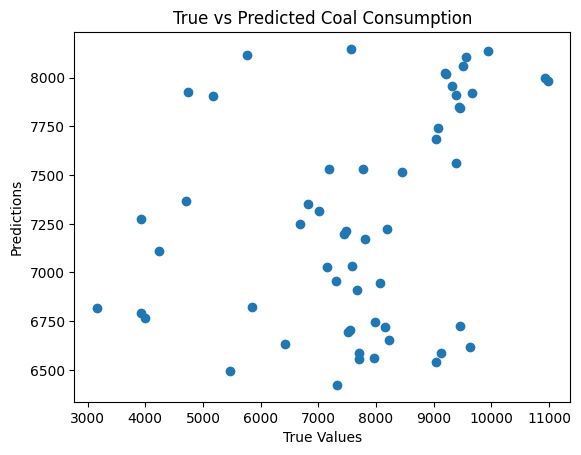

In [83]:
# Plot the predictions
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Coal Consumption')
plt.show()

In [84]:
# Feature importance from the Linear Regression model
feature_importance = pd.DataFrame(model.coef_, X.columns, columns=['Importance'])
print("Feature Importance for Linear Regression Model:")
print(feature_importance)

Feature Importance for Linear Regression Model:
             Importance
tmin (f)  -60087.985687
tmax (f)  -60159.634678
tavg (f)  120283.468482


# ARIMA Model

In [85]:
# Check for stationarity using ADF test
result = adfuller(filtered_df['coal'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.4466388829231577
p-value: 0.9020157171289103


In [86]:
# If p-value > 0.05, difference to achieve stationarity
if result[1] > 0.05:
    filtered_df['coal_diff'] = filtered_df['coal'].diff()
    filtered_df['coal_diff'].dropna(inplace=True)

In [87]:
# Automatically find the best ARIMA parameters (auto-arima)
model_auto = auto_arima(filtered_df['coal'], seasonal=False, stepwise=True, trace=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4433.998, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4512.927, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4498.571, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4493.120, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4511.015, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4451.213, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4432.496, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4494.994, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4482.360, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4433.821, Time=0.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4458.823, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4435.936, Time=2.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4432.117, Time=1.89 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4493.053, Time=1.23 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [88]:
# Fit the ARIMA model on the data
model = ARIMA(filtered_df['coal'], order=(1, 0, 1))  # Adjust p, d, q if needed
model_fit = model.fit()

# Review the ARIMA model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   coal   No. Observations:                  276
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2237.938
Date:                Fri, 06 Dec 2024   AIC                           4483.876
Time:                        06:29:41   BIC                           4498.357
Sample:                    01-01-2001   HQIC                          4489.687
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7440.9456    370.035     20.109      0.000    6715.691    8166.200
ar.L1          0.8164      0.044     18.356      0.000       0.729       0.904
ma.L1          0.3793      0.059      6.471      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [89]:
# Forecasting (for the next 'forecast_steps' periods)
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

<ipython-input-91-c992550e35d9>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')
<ipython-input-91-c992550e35d9>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.fill_between(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:],


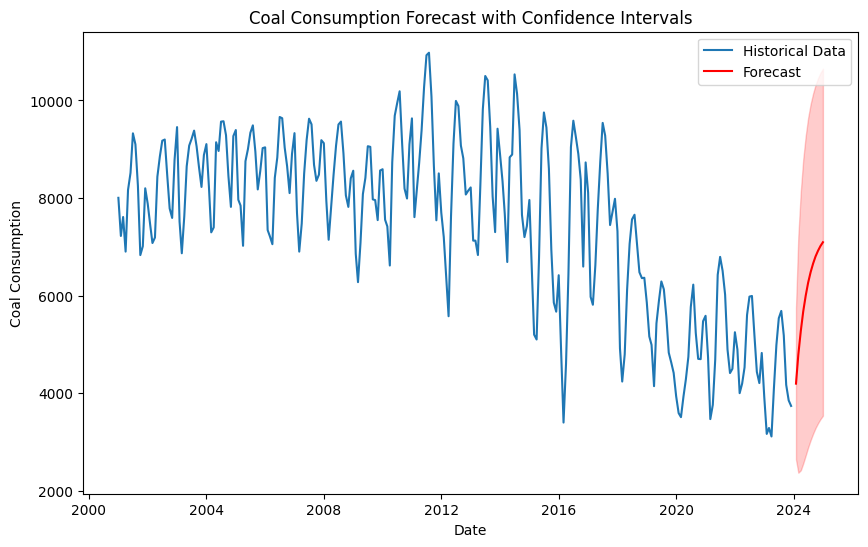

In [91]:
# Plotting the forecast with confidence intervals
forecast_obj = model_fit.get_forecast(steps=forecast_steps)  # Get forecast with confidence intervals
forecast = forecast_obj.predicted_mean  # The predicted forecast values
conf_int = forecast_obj.conf_int(alpha=0.05)  # Confidence intervals for the forecast

# Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['coal'], label='Historical Data')
plt.plot(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')

# Fill the area between the confidence intervals
plt.fill_between(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:],
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)

plt.legend()
plt.title('Coal Consumption Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Coal Consumption')
plt.show()


In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare the exogenous variables (weather data)
X = filtered_df[['tmin (f)', 'tmax (f)', 'tavg (f)']]

# Fit the SARIMAX model (order=(p, d, q) for ARIMA part, seasonal_order=(P, D, Q, S) for seasonal part)
model_sarimax = SARIMAX(filtered_df['coal'], exog=X, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit_sarimax = model_sarimax.fit(disp=False)

# Review the SARIMAX model summary
print(model_fit_sarimax.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               coal   No. Observations:                  276
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2158.681
Date:                            Fri, 06 Dec 2024   AIC                           4333.362
Time:                                    06:33:21   BIC                           4362.325
Sample:                                01-01-2001   HQIC                          4344.984
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmin (f)    3.083e+04     22.944   1343.810      0.000    3.08e+04    3.09e+04
tmax (f)    3.071e+04     21.278   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-94-bc0073bf7303>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast_exog, label='Forecast', color='red')


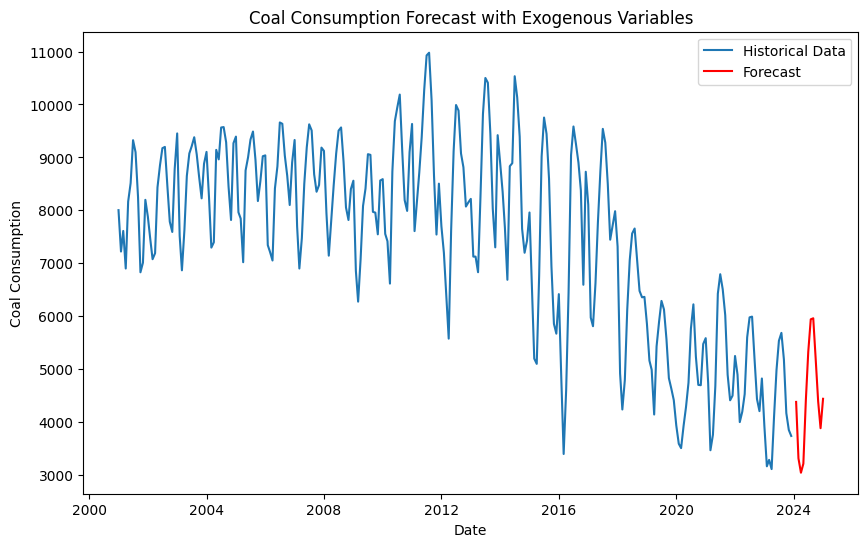

In [94]:
# Prepare future exogenous variables (e.g., weather data for future periods)
future_exog = pd.DataFrame({
    'tmin (f)': [30, 32, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
    'tmax (f)': [50, 52, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'tavg (f)': [40, 42, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
})

# Forecast with the SARIMAX model and future exogenous variables
forecast_exog = model_fit_sarimax.forecast(steps=forecast_steps, exog=future_exog)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['coal'], label='Historical Data')
plt.plot(pd.date_range(filtered_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast_exog, label='Forecast', color='red')
plt.legend()
plt.title('Coal Consumption Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Coal Consumption')
plt.show()
